<a href="https://colab.research.google.com/github/gondore/nsdc-crafter/blob/main/experimental_dqn_nsdc_crafter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium crafter stable_baselines3 shimmy[gym-v26]

In [12]:
from google.colab import drive
drive.mount('/content/crafter_official_data')

ValueError: Mountpoint must not already contain files

In [13]:
import gymnasium as gym
import crafter


#env = gym.make("GymV26Environment-v0", env_id = 'CrafterReward-v1')  # Or CrafterNoReward-v1
env = crafter.Env()
env = crafter.Recorder(
  env, '/content/crafter_official_data',
  save_stats=True,
  save_video=True,
  save_episode=False,
)
import matplotlib.pyplot as plt
import numpy as np

It looks like our observation space is image data? 64x64x3 (height x width x channel)

In [ ]:
print("Observation Space", env.observation_space)


In [ ]:
observation_space = env.observation_space

According to crafter documentation, (https://github.com/danijar/crafter/blob/e04542a2159f1aad3d4c5ad52e8185717380ee3a/crafter/env.py#L15)

```
  def observation_space(self):
    return BoxSpace(0, 255, tuple(self._size) + (3,), np.uint8)
```

 I believe the observation space is in the form of BoxSpace, which I'm not familiar with. This plot below is just a quick script that visualizes the observation space. I think we will have to work with image data and flatten it to state representations?


In [14]:
import tensorflow as tf
import numpy as np


from skimage import transform # preprocess the frames
from skimage.color import rgb2gray # grayscale frames

import matplotlib.pyplot as plt

from collections import deque# Ordered collection with ends

import random

import warnings # reduce clutter of warnings
warnings.filterwarnings('ignore')

In [15]:
print("The action size is : ", env.action_space.n)
# one hot encode actions, (e.g. walk up ('w' keybinding) is (1, 0, 0, ..., 0) (16 zeros) )
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())


The action size is :  17


**Preprocessing observationspace**
- grayscale frames
- normalizing pixel values
- resize preprocessed frame


In [9]:
def preprocess_frame(frame):
    # Greyscale frame
    gray = rgb2gray(frame)

    # Normalize Pixel Values
    normalized_frame = frame/255.0

    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, [110,84])

    return preprocessed_frame # 110x84x1 frame

**stack_frames**

In [16]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((110,84), dtype=int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)

    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=int) for i in range(stack_size)], maxlen=4)

        # copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)

        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2)

    return stacked_state, stacked_frames

**Hyperparameter setup**

In [17]:
### MODEL HYPERPARAMETERS
state_size = [110, 84, 4]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels)
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

**DQN implementation**

In [18]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        with tf.compat.v1.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each element of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.keras.Input(shape=state_size, dtype=tf.float32, name="inputs")
            self.actions_ = tf.keras.Input(shape=(self.action_size,), dtype=tf.float32, name="actions_")

            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.keras.Input(shape=(1,), dtype=tf.float32, name="target")

            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.keras.layers.Conv2D(filters=32,
                                                kernel_size=(8, 8),
                                                strides=(4, 4),
                                                padding="VALID",
                                                kernel_initializer=tf.initializers.GlorotUniform(),
                                                name="conv1")
            self.conv1_out = tf.keras.layers.ELU(name="conv1_out")

            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.keras.layers.Conv2D(filters=64,
                                                kernel_size=(4, 4),
                                                strides=(2, 2),
                                                padding="VALID",
                                                kernel_initializer=tf.initializers.GlorotUniform(),
                                                name="conv2")
            self.conv2_out = tf.keras.layers.ELU(name="conv2_out")

            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.keras.layers.Conv2D(filters=64,
                                                kernel_size=(3, 3),
                                                strides=(2, 2),
                                                padding="VALID",
                                                kernel_initializer=tf.initializers.GlorotUniform(),
                                                name="conv3")
            self.conv3_out = tf.keras.layers.ELU(name="conv3_out")

            self.flatten = tf.keras.layers.Flatten()
            self.fc = tf.keras.layers.Dense(units=512,
                                             activation=tf.keras.activations.elu,
                                             kernel_initializer=tf.initializers.GlorotUniform(),
                                             name="fc1")
            self.output = tf.keras.layers.Dense(units=self.action_size,
                                                 activation=None,
                                                 kernel_initializer=tf.initializers.GlorotUniform(),
                                                 name="output")

            # Connect the layers
            x = self.conv1(self.inputs_)
            x = self.conv1_out(x)
            x = self.conv2(x)
            x = self.conv2_out(x)
            x = self.conv3(x)
            x = self.conv3_out(x)
            x = self.flatten(x)
            x = self.fc(x)
            self.output_ = self.output(x)

            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output_, self.actions_))

            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))

            # Get the list of trainable variables
            self.trainable_variables = self.conv1.trainable_variables + \
                                        self.conv1_out.trainable_variables + \
                                        self.conv2.trainable_variables + \
                                        self.conv2_out.trainable_variables + \
                                        self.conv3.trainable_variables + \
                                        self.conv3_out.trainable_variables + \
                                        self.fc.trainable_variables + \
                                        self.output.trainable_variables

            # Create an optimizer
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def train(self, inputs, actions, target_Q):
        with tf.GradientTape() as tape:
            # Forward pass
            predicted_Q = self(inputs)
            # Calculate the loss
            loss = tf.reduce_mean(tf.square(target_Q - predicted_Q))

        # Get gradients of loss w.r.t. the trainable variables
        gradients = tape.gradient(loss, self.trainable_variables)
        # Apply gradients using the optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss


In [19]:
# Reset the graph
tf.compat.v1.reset_default_graph()
# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

In [20]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)

        return [self.buffer[i] for i in index]

In [21]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)

    # Get the next_state, the rewards, done by taking a random action
    choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    next_state, reward, done, _ = env.step(np.argmax(action))

    #env.render()

    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)


    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)

        # Add experience to memory
        memory.add((state, action, reward, next_state, done))

        # Start a new episode
        state = env.reset()

        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)

    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))

        # Our new state is now the next_state
        state = next_state

In [ ]:
# Setup TensorBoard Writer
#writer = tf.summary.FileWriter("/tensorboard/dqn/1")

## Losses
#tf.summary.scalar("Loss", DQNetwork.loss)

#write_op = tf.summary.merge_all()

In [22]:
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)

    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]

    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})

        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[choice]


    return action, explore_probability

In [23]:
# Saver will help us to save our model
#saver = tf.train.Saver()

if training == True:


    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())

        # Initialize the decay rate (that will use to reduce epsilon)
        decay_step = 0

        for episode in range(total_episodes):
            # Set step to 0
            step = 0

            # Initialize the rewards of the episode
            episode_rewards = []

            # Make a new episode and observe the first state
            state = env.reset()

            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)

            while step < max_steps:
                step += 1

                #Increase decay_step
                decay_step +=1

                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

                #Perform the action and get the next_state, reward, and done information
                next_state, reward, done, _ = env.step(action)

                if episode_render:
                    env.render()

                # Add the reward to total reward
                episode_rewards.append(reward)

                # If the game is finished
                if done:
                    # The episode ends so no next state
                    next_state = np.zeros((110,84), dtype=np.int)

                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                                  'Total reward: {}'.format(total_reward),
                                  'Explore P: {:.4f}'.format(explore_probability),
                                'Training Loss {:.4f}'.format(loss))

                    rewards_list.append((episode, total_reward))

                    # Store transition <st,at,rt+1,st+1> in memory D
                    memory.add((state, action, reward, next_state, done))

                else:
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))

                    # st+1 is now our current state
                    state = next_state


                ### LEARNING PART
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch])
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                # Get Q values for next_state
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})

                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])

                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)


                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                        feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = model.save("./models/model.ckpt")
                print("Model Saved")

In [24]:
pip install gymnasium torch numpy matplotlib


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt



class ConvDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvDQN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4),  # input channels = 3 for RGB images
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),  # This needs to be adjusted based on the output size of the conv layers
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Change image format from HWC to CHW expected by PyTorch
        conv_out = self.conv_layers(x).reshape(x.size(0), -1)  # Flatten the output for the FC layers
        return self.fc_layers(conv_out)



In [26]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)


In [27]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = ConvDQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters())
        self.criterion = nn.MSELoss()
        self.epsilon = 0.99
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.gamma = 0.99

    def act(self, state):
        if random.random() > self.epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.model(state)
            action = q_values.max(1)[1].item()
        else:
            action = random.randrange(self.action_dim)
        return action

    def train(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [28]:
state_dim = np.prod(env.observation_space.shape)  # This ensures a flat vector input size is correctly identified
action_dim = env.action_space.n

#state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(state_dim, action_dim, replay_buffer)

def train_dqn(episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            agent.train(32)
            if done:
                break
        rewards.append(episode_reward)
        print(f'Episode: {episode}, Reward: {episode_reward}')
        agent.epsilon = max(agent.epsilon_min, agent.epsilon_decay * agent.epsilon)  # Decay epsilon
    return rewards

episodes = 500
rewards = train_dqn(episodes)


Episode: 0, Reward: 0.10000000000000006
Episode: 1, Reward: 1.1
Episode: 2, Reward: 1.1
Episode: 3, Reward: 1.1
Episode: 4, Reward: 3.099999999999999
Episode: 5, Reward: 2.1
Episode: 6, Reward: 4.1
Episode: 7, Reward: 3.099999999999999
Episode: 8, Reward: 2.099999999999999
Episode: 9, Reward: 2.099999999999999
Episode: 10, Reward: 1.1
Episode: 11, Reward: 2.099999999999999
Episode: 12, Reward: 3.099999999999999
Episode: 13, Reward: 4.099999999999999
Episode: 14, Reward: 2.0999999999999996
Episode: 15, Reward: 2.099999999999999
Episode: 16, Reward: 2.099999999999999
Episode: 17, Reward: 2.099999999999999
Episode: 18, Reward: 3.0999999999999996
Episode: 19, Reward: 3.099999999999999
Episode: 20, Reward: 1.1000000000000008
Episode: 21, Reward: 2.099999999999999
Episode: 22, Reward: 1.1
Episode: 23, Reward: 1.1000000000000003
Episode: 24, Reward: 1.1000000000000003
Episode: 25, Reward: 1.1
Episode: 26, Reward: 1.1000000000000003
Episode: 27, Reward: 2.099999999999999
Episode: 28, Reward: 1

In [30]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
import os

video_directory = '/content/crafter_official_data'  # Ensure this is your correct directory
video_files = [f for f in os.listdir(video_directory) if f.endswith('.mp4')]

# Debug: Print out video files found (or not found)
print("Found video files:", video_files)

if not video_files:
    raise ValueError("No video files found in the directory.")

video_files.sort()  # Make sure this sorts the files in the order you expect

# Full paths to video files
video_paths = [os.path.join(video_directory, f) for f in video_files]

# Load video clips
clips = [VideoFileClip(f) for f in video_paths]

# Concatenate the video clips
final_clip = concatenate_videoclips(clips)

# Save the concatenated video
final_video_path = os.path.join(video_directory, 'final_training_video.mp4')
final_clip.write_videofile(final_video_path)


Found video files: ['20240219T193622-ach2-len182.mp4', '20240219T203632-ach3-len234.mp4', '20240219T194523-ach2-len189.mp4', '20240219T183705-ach2-len81.mp4', '20240219T185036-ach2-len163.mp4', '20240219T201424-ach2-len58.mp4', '20240219T205941-ach2-len159.mp4', '20240219T203144-ach2-len185.mp4', '20240219T200108-ach2-len190.mp4', '20240219T184529-ach2-len179.mp4', '20240219T201602-ach2-len196.mp4', '20240219T200833-ach2-len160.mp4', '20240219T202952-ach1-len53.mp4', '20240219T191619-ach3-len58.mp4', '20240219T184119-ach3-len176.mp4', '20240219T195613-ach2-len151.mp4', '20240219T191739-ach2-len211.mp4', '20240219T194008-ach2-len85.mp4', '20240219T210102-ach2-len185.mp4', '20240219T205116-ach2-len153.mp4', '20240219T202739-ach2-len154.mp4', '20240219T194857-ach3-len121.mp4', '20240219T193723-ach3-len200.mp4', '20240219T185601-ach2-len86.mp4', '20240219T210637-ach3-len161.mp4', '20240219T205608-ach3-len218.mp4', '20240219T200505-ach2-len153.mp4', '20240219T204435-ach2-len222.mp4', '20240

Moviepy - Done !
Moviepy - video ready /content/crafter_official_data/final_training_video.mp4


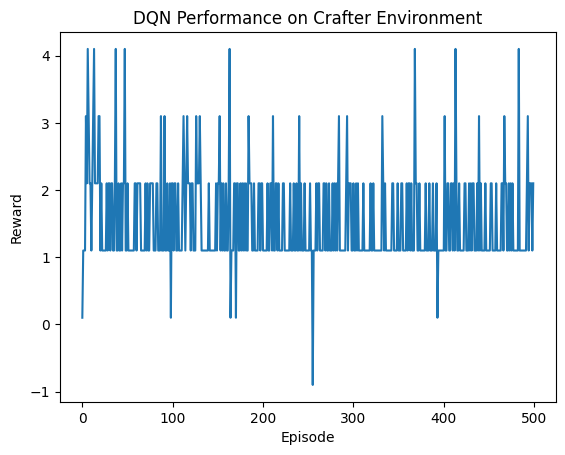

In [31]:
plt.plot(range(episodes), rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Performance on Crafter Environment')
plt.show()

In [ ]:
!pip install pandas matplotlib


In [32]:
import json
import pandas as pd

stats_file_path = '/content/crafter_official_data/stats.jsonl'  # Adjust this to your file's location

# Initialize an empty list to hold JSON objects
stats_data = []

# Load each line of the JSON data
with open(stats_file_path, 'r') as file:
    for line in file:
        # Each line contains a valid JSON object
        stats_data.append(json.loads(line))

# If your JSON objects are dictionaries with consistent keys,
# this will create a DataFrame where each key becomes a column
df_stats = pd.DataFrame(stats_data)



In [33]:
# Display the first few rows of the DataFrame
print(df_stats.head())

# Summary statistics
print(df_stats.describe())


   length  reward  achievement_collect_coal  achievement_collect_diamond  \
0     214     0.1                         0                            0   
1     133     1.1                         0                            0   
2      68     1.1                         0                            0   
3     252     1.1                         0                            0   
4     184     3.1                         0                            0   

   achievement_collect_drink  achievement_collect_iron  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

   achievement_collect_sapling  achievement_collect_stone  \
0                            0                          0   
1                            2                          0   
2          

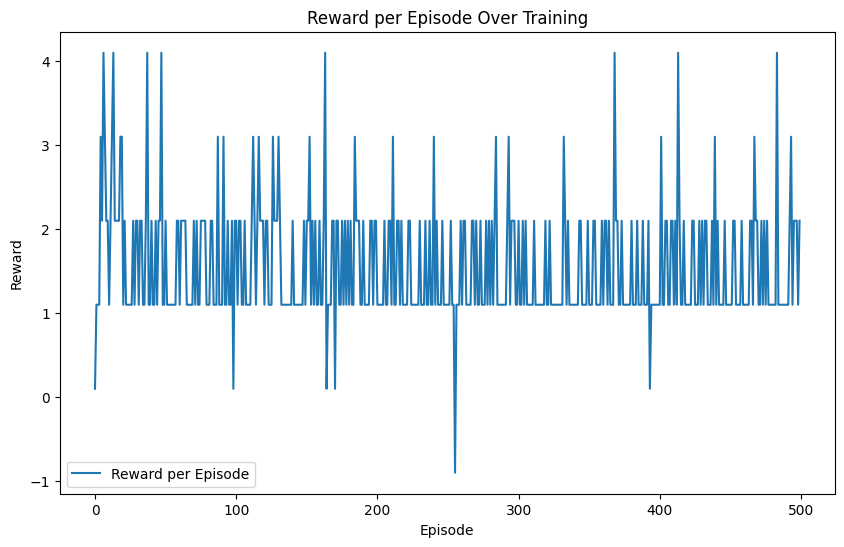

In [36]:
import matplotlib.pyplot as plt

# Assuming 'reward' is the name of the column storing the reward per episode
plt.figure(figsize=(10, 6))
plt.plot(df_stats.index, df_stats['reward'], label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode Over Training')
plt.legend()
plt.show()


In [37]:
import gym
import crafter
import dreamerv2.api as dv2

config = dv2.defaults
config = config.update(dv2.configs['crafter'])
config = config.parse_flags()

env = gym.make('CrafterReward-v1')
env = crafter.Recorder(
    env, config.logdir,
    save_stats=True,
    save_video=False,
    save_episode=False,
)

dv2.train(env, config, [dv2.TerminalOutput()])

ModuleNotFoundError: No module named 'dreamerv2'